In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from collections import Counter
import seaborn as sns

sns.set_theme()
sns.set_context("poster")
sns.set_palette("colorblind")

colors = sns.color_palette("colorblind")


In [8]:
# Loading in SOPHIE Data
sophie80df = pd.read_csv("Data/SOPHIE_EPT80_1990-2022.csv", low_memory=False)
sophie80df['Date_UTC'] = pd.to_datetime(sophie80df['Date_UTC'])
sophie80df = sophie80df[sophie80df['Date_UTC'].between('1996','2022')].reset_index(drop=True)
sophie80df['Duration'] = np.append(np.diff(sophie80df['Date_UTC']), np.array([pd.to_timedelta(0,'h')],dtype=np.timedelta64))
sophie80df['Delbay'] = pd.to_numeric(sophie80df['Delbay'],errors='coerce')

array = np.zeros(len(sophie80df['Date_UTC']),dtype=int)
for i in range(4,len(sophie80df['Date_UTC'])-2):
    if (sophie80df.iloc[i-4]['Phase'] == 1) and (sophie80df.iloc[i-3]['Phase'] == 2) and (sophie80df.iloc[i-3]['Flag'] == 0) and (sophie80df.iloc[i-2]['Phase'] == 3) and (sophie80df.iloc[i-1]['Phase'] == 1) and (sophie80df.iloc[i]['Phase'] == 2) and (sophie80df.iloc[i+1]['Phase'] == 3) and (sophie80df.iloc[i+2]['Phase'] == 1) :
        array[i] = 1
        continue
    else:
        array[i] = 0
        continue

sophie80df['GERG'] = array

array = np.zeros(len(sophie80df['Date_UTC']),dtype=int)
for i in range(2,len(sophie80df['Date_UTC'])-1):
    if (sophie80df.iloc[i-2]['Phase'] == 2) and (sophie80df.iloc[i-2]['Flag'] == 0) and (sophie80df.iloc[i-1]['Phase'] == 3) and (sophie80df.iloc[i]['Phase'] == 2) and (sophie80df.iloc[i+1]['Phase'] == 3):
        array[i] = 1
        continue
    else:
        array[i] = 0
        continue

sophie80df['ERER'] = array

# choosing only sophie onsets
sophie80onsetdf = sophie80df.iloc[np.where(sophie80df['Phase']==2)]
sophie80onsetdf = sophie80onsetdf.reset_index(drop=True)
phaseafter = sophie80df['Date_UTC'].iloc[np.where(sophie80df[:-1]['Phase']==2)[0]+1].reset_index(drop=True) 
sophie80onsetdf['Waiting Time'] = np.insert(np.array(pd.to_timedelta(np.diff(sophie80onsetdf['Date_UTC']))),0,[pd.to_timedelta(0,'h')])
sophie80onsetdf['Time to Next'] = np.append(np.array(pd.to_timedelta(np.diff(sophie80onsetdf['Date_UTC']))),np.array([pd.to_timedelta(0,'h')],dtype=np.timedelta64))
sophie80onsetdf['Delbay'] = pd.to_numeric(sophie80onsetdf['Delbay'],errors='coerce')

# Loading in SuperMAG Data
supermagdatadf = pd.read_csv('Data/SuperMAGData.csv')
supermagdatadf['Date_UTC'] = pd.to_datetime(supermagdatadf['Date_UTC'])
supermagdatadf[supermagdatadf['Date_UTC'].between('1995','2022')]
supermagdatadf['SML'].replace(999999, np.nan, inplace=True)
supermagdatadf['SMU'].replace(999999, np.nan, inplace=True)

# Loading in OMNI Data
omnidf = pd.read_csv('Data/OMNIData.csv')
omnidf['Date_UTC'] = pd.to_datetime(omnidf['Date_UTC'])
omnidf = omnidf[omnidf['Date_UTC'].between('1995','2022')]


In [9]:
# Finding the indices of the first and last sophie onsets in a gerg
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
a = x - 1
b = np.setdiff1d(a,x)
firstgerg = sophie80onsetdf.iloc[np.intersect1d(b,y)]
gergnoflag = sophie80onsetdf.iloc[np.concatenate((x,b))]

# # Finding the indices of the first and last sophie onsets in a erer
x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
a = x - 1
b = np.setdiff1d(a,x)
firster = sophie80onsetdf.iloc[np.intersect1d(b,y)]
erernoflag = sophie80onsetdf.iloc[np.concatenate((x,b))]

## Distributions from SOPHIE

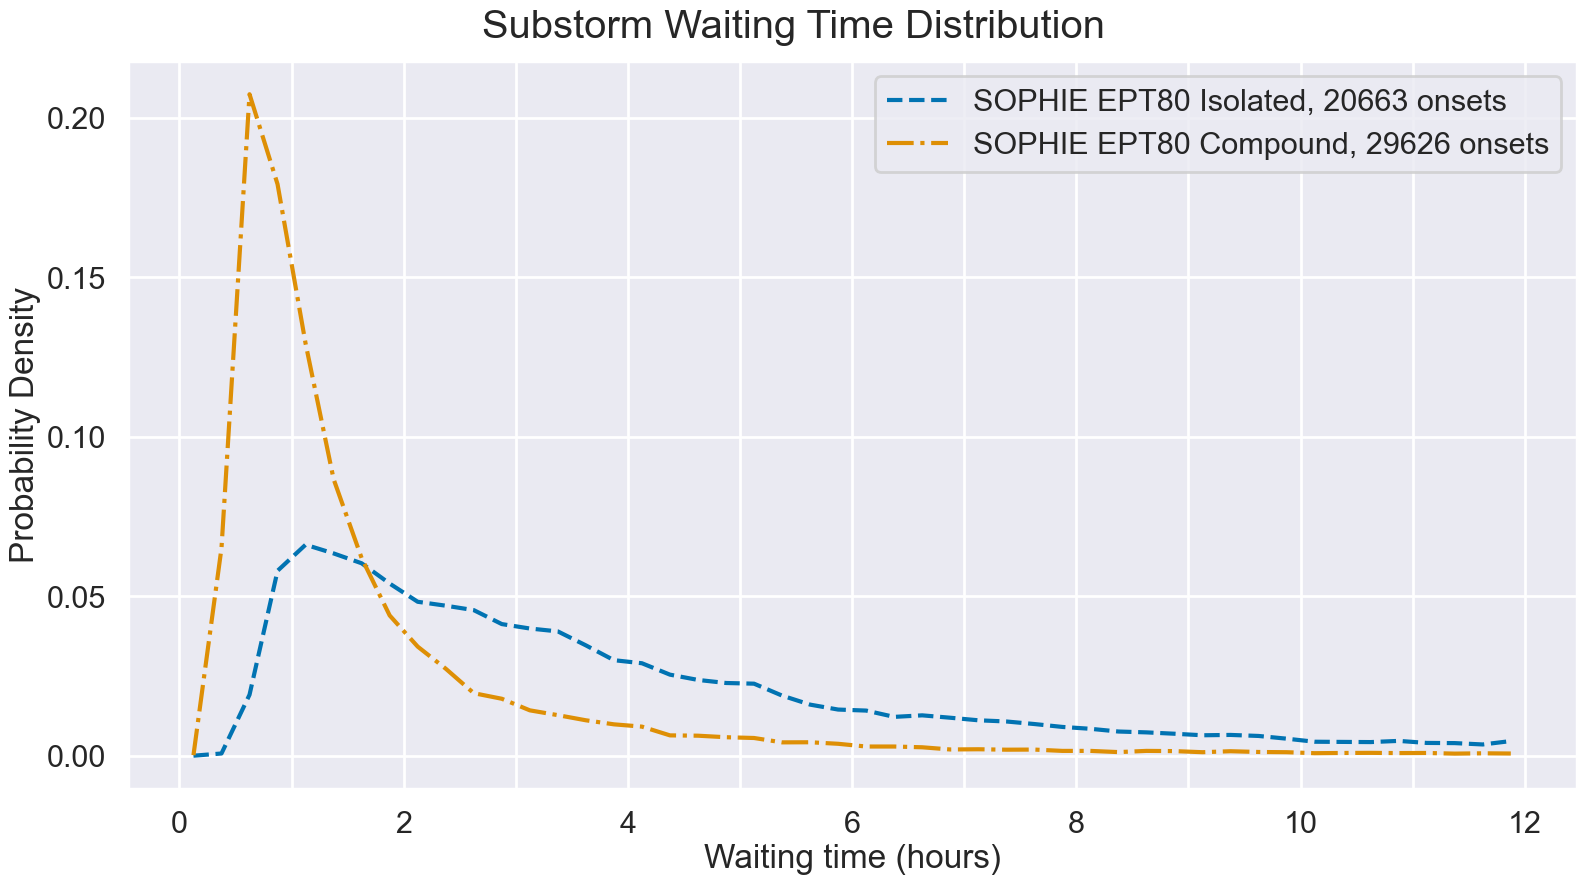

In [12]:
def waitingtime_hist(array):
    x, y = np.histogram(array['Waiting Time']/pd.to_timedelta(1,'h'),bins=np.arange(0,12.25,.25))
    y = y+.125
    y = y[:-1]
    d = {'Waiting Time':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df



onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 Isolated','SOPHIE EPT80 Compound']
onsetnumbers = [len(i) for i in onsetlists]
means = [np.mean(i['Waiting Time'])/pd.Timedelta(1,'h') for i in onsetlists]
stdevs = [np.std(i['Waiting Time'])/pd.Timedelta(1,'h') for i in onsetlists]
medians = [np.median(i['Waiting Time'])/pd.Timedelta(1,'h') for i in onsetlists]
# labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]
labels = ["{}, {} onsets".format(labels[i],onsetnumbers[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [waitingtime_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(16,9))

for i in range(1,len(onsetlists)):
    axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i], ls=lines[i])
    
axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))
axes.set_xlabel('Waiting time (hours)')
axes.set_ylabel('Probability Density')
axes.grid(True,'both')
fig.suptitle('Substorm Waiting Time Distribution')
# fig.legend(bbox_to_anchor=(1, .5), loc='center left')
axes.legend(loc='upper right')
fig.tight_layout(pad=0.5)

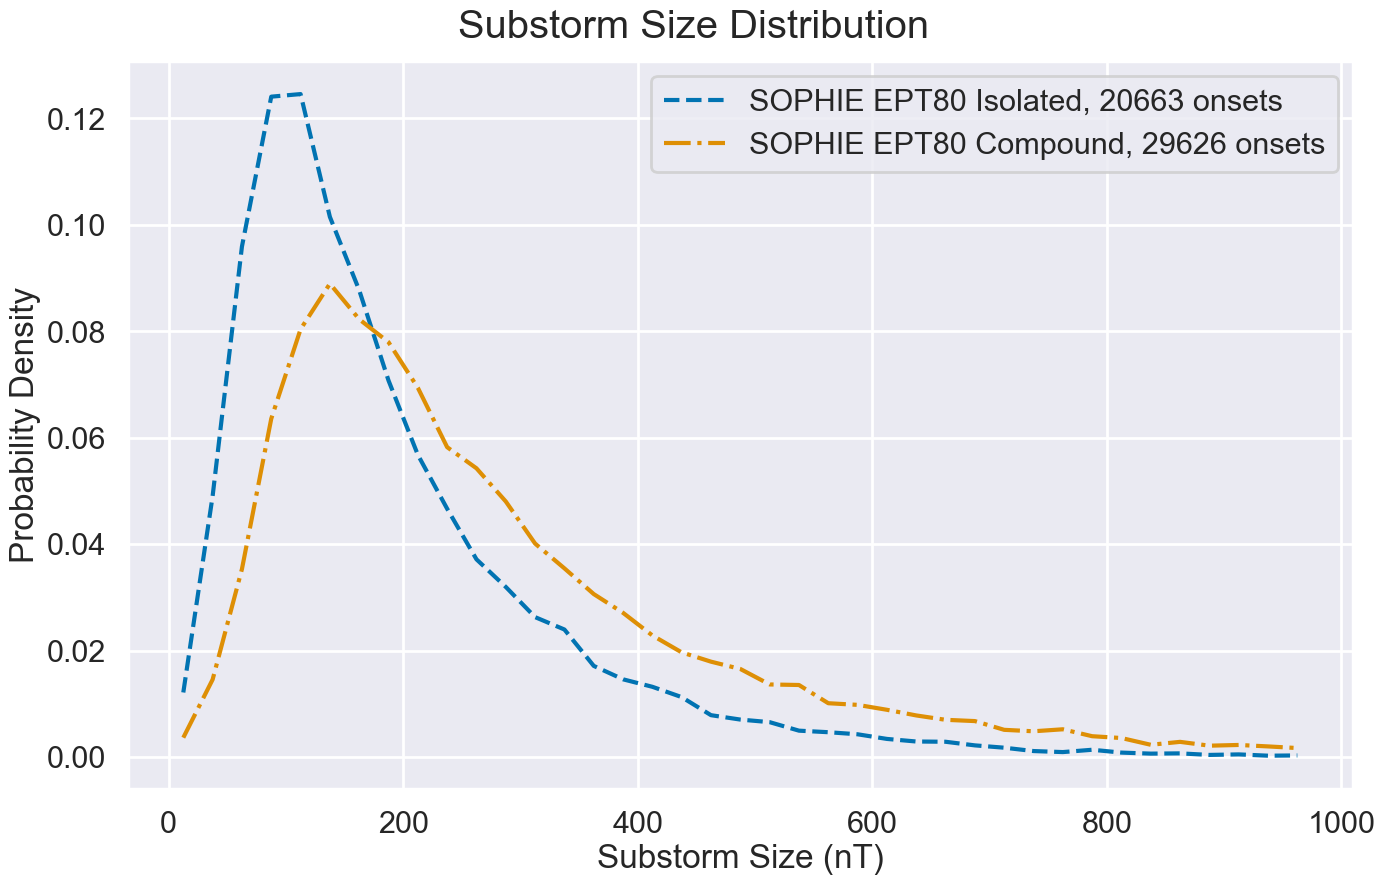

In [13]:
def size_hist(array):
    x, y = np.histogram(-array['Delbay'],bins=np.arange(0,1000,25))
    y = y + 12.5
    y = y[:-1]
    d = {'Size':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 Isolated','SOPHIE EPT80 Compound']
onsetnumbers = [len(i) for i in onsetlists]
means = [np.nanmean(-i['Delbay']) for i in onsetlists]
stdevs = [np.nanstd(-i['Delbay']) for i in onsetlists]
medians = [np.nanmedian(-i['Delbay']) for i in onsetlists]
# labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]
labels = ["{}, {} onsets".format(labels[i],onsetnumbers[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [size_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(14,9))

for i in range(1,len(onsetlists)):
    axes.plot(wts[i]['Size'],wts[i]['Density'], label=labels[i],ls=lines[i])
    
axes.set_xlabel('Substorm Size (nT)')
axes.set_ylabel('Probability Density')
axes.grid(True,'both')
fig.suptitle('Substorm Size Distribution')
# fig.legend(bbox_to_anchor=(1, .5), loc='center left')
axes.legend(loc='upper right')
fig.tight_layout(pad=0.5)

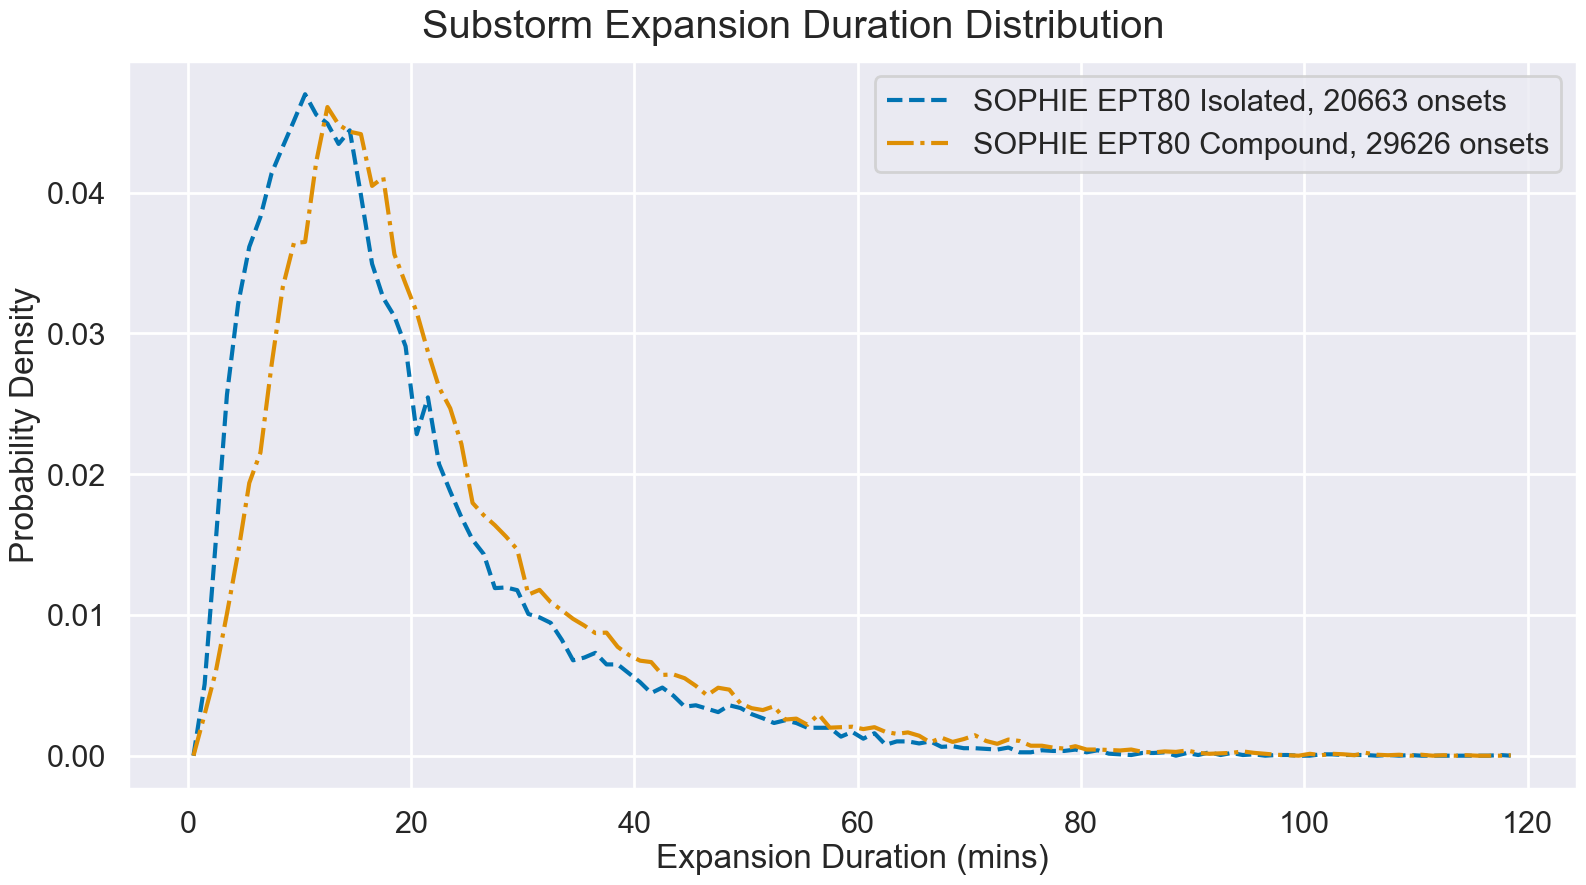

In [14]:
def duration_hist(array):
    x, y = np.histogram(array['Duration']/pd.to_timedelta(1,'m'),bins=np.arange(0,120,1))
    y = y+.5
    y = y[:-1]
    d = {'Duration':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 Isolated','SOPHIE EPT80 Compound']
onsetnumbers = [len(i) for i in onsetlists]
means = [np.mean(i['Duration'])/pd.Timedelta(1,'m') for i in onsetlists]
stdevs = [np.std(i['Duration'])/pd.Timedelta(1,'m') for i in onsetlists]
medians = [np.median(i['Duration'])/pd.Timedelta(1,'m') for i in onsetlists]
# labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]
labels = ["{}, {} onsets".format(labels[i],onsetnumbers[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [duration_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(16,9))

for i in range(1,len(onsetlists)):
    axes.plot(wts[i]['Duration'],wts[i]['Density'], label=labels[i], ls=lines[i])
    
axes.set_xlabel('Expansion Duration (mins)')
axes.set_ylabel('Probability Density')
axes.grid(True,'both')
fig.suptitle('Substorm Expansion Duration Distribution')
# fig.legend(bbox_to_anchor=(1, .5), loc='center left')
axes.legend(loc='upper right')
fig.tight_layout(pad=0.5)

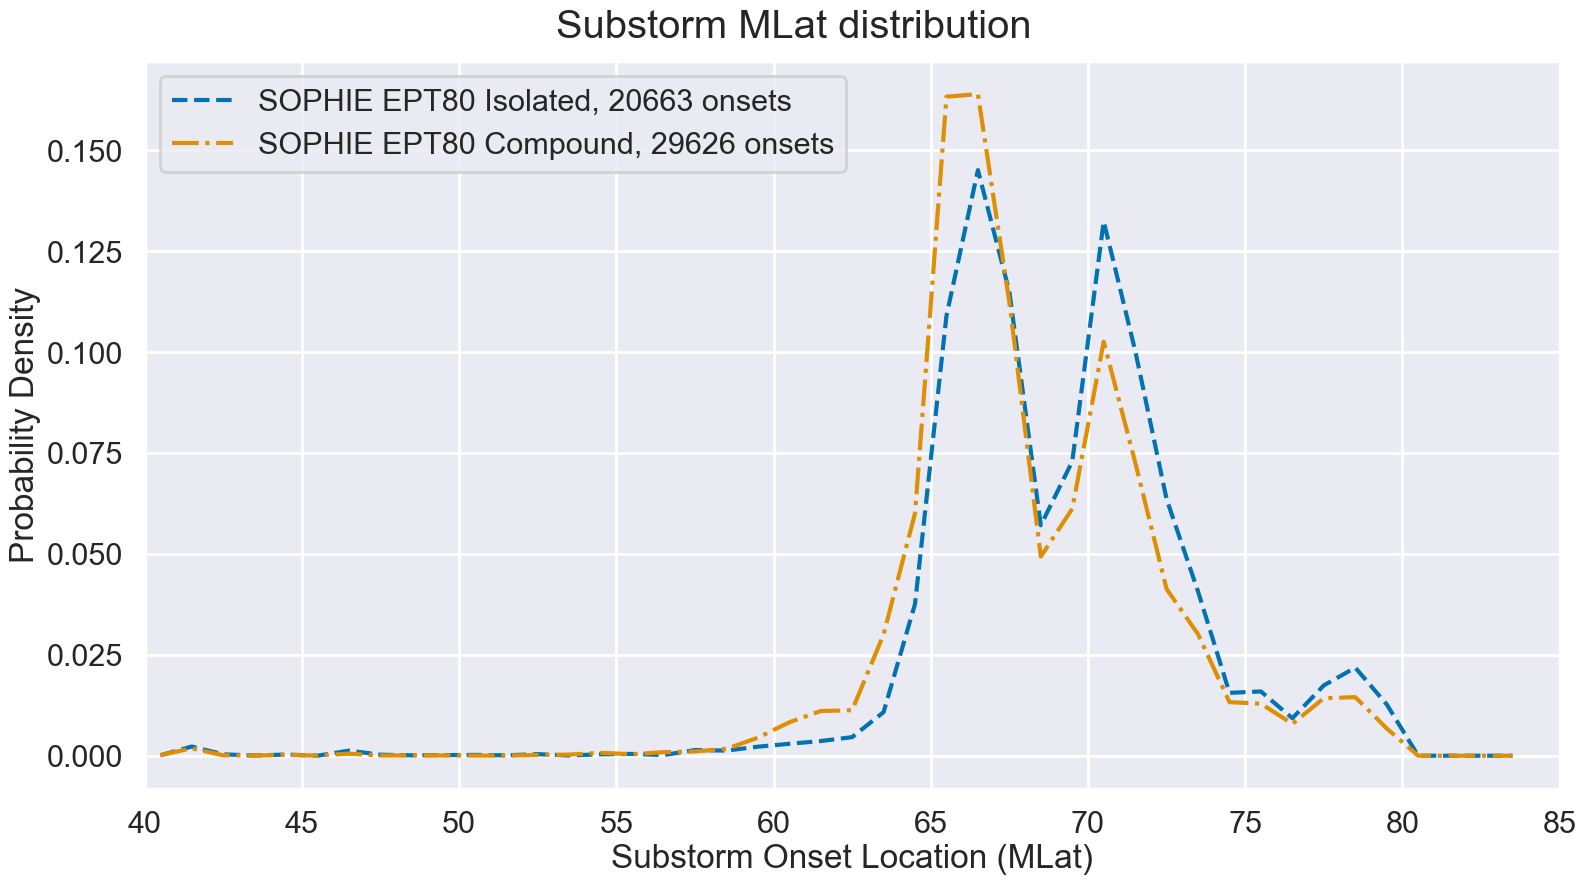

In [15]:
def mlat_hist(array):
    x, y = np.histogram(array['MLat'],bins=np.arange(40,85,1))
    y = y + .5
    y = y[:-1]
    d = {'MLat':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 Isolated','SOPHIE EPT80 Compound']
onsetnumbers = [len(i) for i in onsetlists]
means = [np.mean(i['MLat']) for i in onsetlists]
stdevs = [np.std(i['MLat']) for i in onsetlists]
medians = [np.median(i['MLat']) for i in onsetlists]
# labels = ["{}, {} onsets, mean:  {:.2f}, st. dev: {:.2f}, median: {:.2f}".format(labels[i],onsetnumbers[i],means[i],stdevs[i],medians[i]) for i in range(len(onsetlists))]
labels = ["{}, {} onsets".format(labels[i],onsetnumbers[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [mlat_hist(i) for i in onsetlists]
fig, axes = plt.subplots(figsize=(16,9))

for i in range(1,len(onsetlists)):
    axes.plot(wts[i]['MLat'],wts[i]['Density'], label=labels[i],ls=lines[i])
    

axes.set_xlim(40,85)
axes.set_xlabel('Substorm Onset Location (MLat)')
axes.set_ylabel('Probability Density')
axes.grid(True,'both')
fig.suptitle('Substorm MLat distribution')
# fig.legend(bbox_to_anchor=(1, .5), loc='center left')
axes.legend(loc='upper left')
fig.tight_layout(pad=0.5)


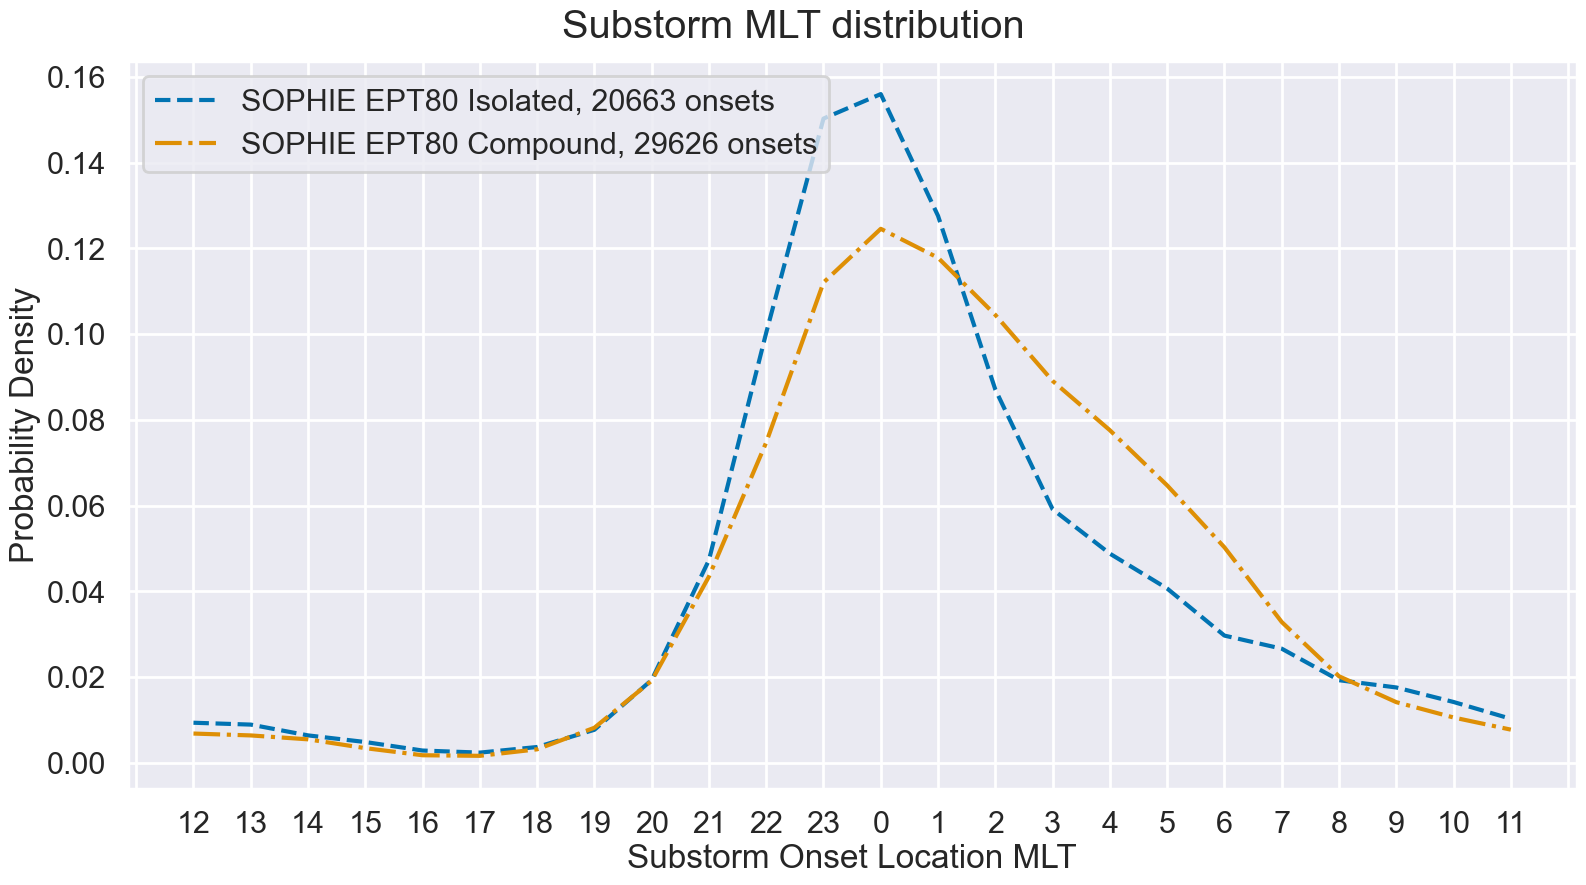

In [16]:
def mlt_hist(array):
    x, y = np.histogram(array['MLT'],bins=np.arange(0,25))
    y = y
    y = y[:-1]
    d = {'MLT':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

onsetlists = [sophie80onsetdf, gergnoflag, erernoflag]
labels = ['SOPHIE EPT80 All', 'SOPHIE EPT80 Isolated','SOPHIE EPT80 Compound']
onsetnumbers = [len(i) for i in onsetlists]
means = [np.mean(i['MLT']) for i in onsetlists]
stdevs = [np.std(i['MLT']) for i in onsetlists]
medians = [np.median(i['MLT']) for i in onsetlists]
# labels = ["{}, {} onsets".format(labels[i],onsetnumbers[i]) for i in range(len(onsetlists))]
labels = ["{}, {} onsets".format(labels[i],onsetnumbers[i]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot']
wts = [mlt_hist(i) for i in onsetlists]

fig, axes = plt.subplots(figsize=(16,9))
idx = np.array([np.arange(12,24),np.arange(0,12)]).flatten()
xx = [wts[i]['MLT'][idx].to_numpy().astype(str) for i in range(len(onsetlists))]
yy = [wts[i]['Density'][idx].to_numpy() for i in range(len(onsetlists))]

for i in range(1,len(onsetlists)):
    axes.plot(xx[i],yy[i], label=labels[i],ls=lines[i])

    
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))
axes.set_xlabel('Substorm Onset Location MLT')
axes.set_ylabel('Probability Density')
axes.grid(True,'both')
fig.suptitle('Substorm MLT distribution')
# fig.legend(bbox_to_anchor=(1, .5), loc='center left')
axes.legend(loc='upper left')
fig.tight_layout(pad=0.5)

## Chains of Substorm Activity -  Transition Probabilities

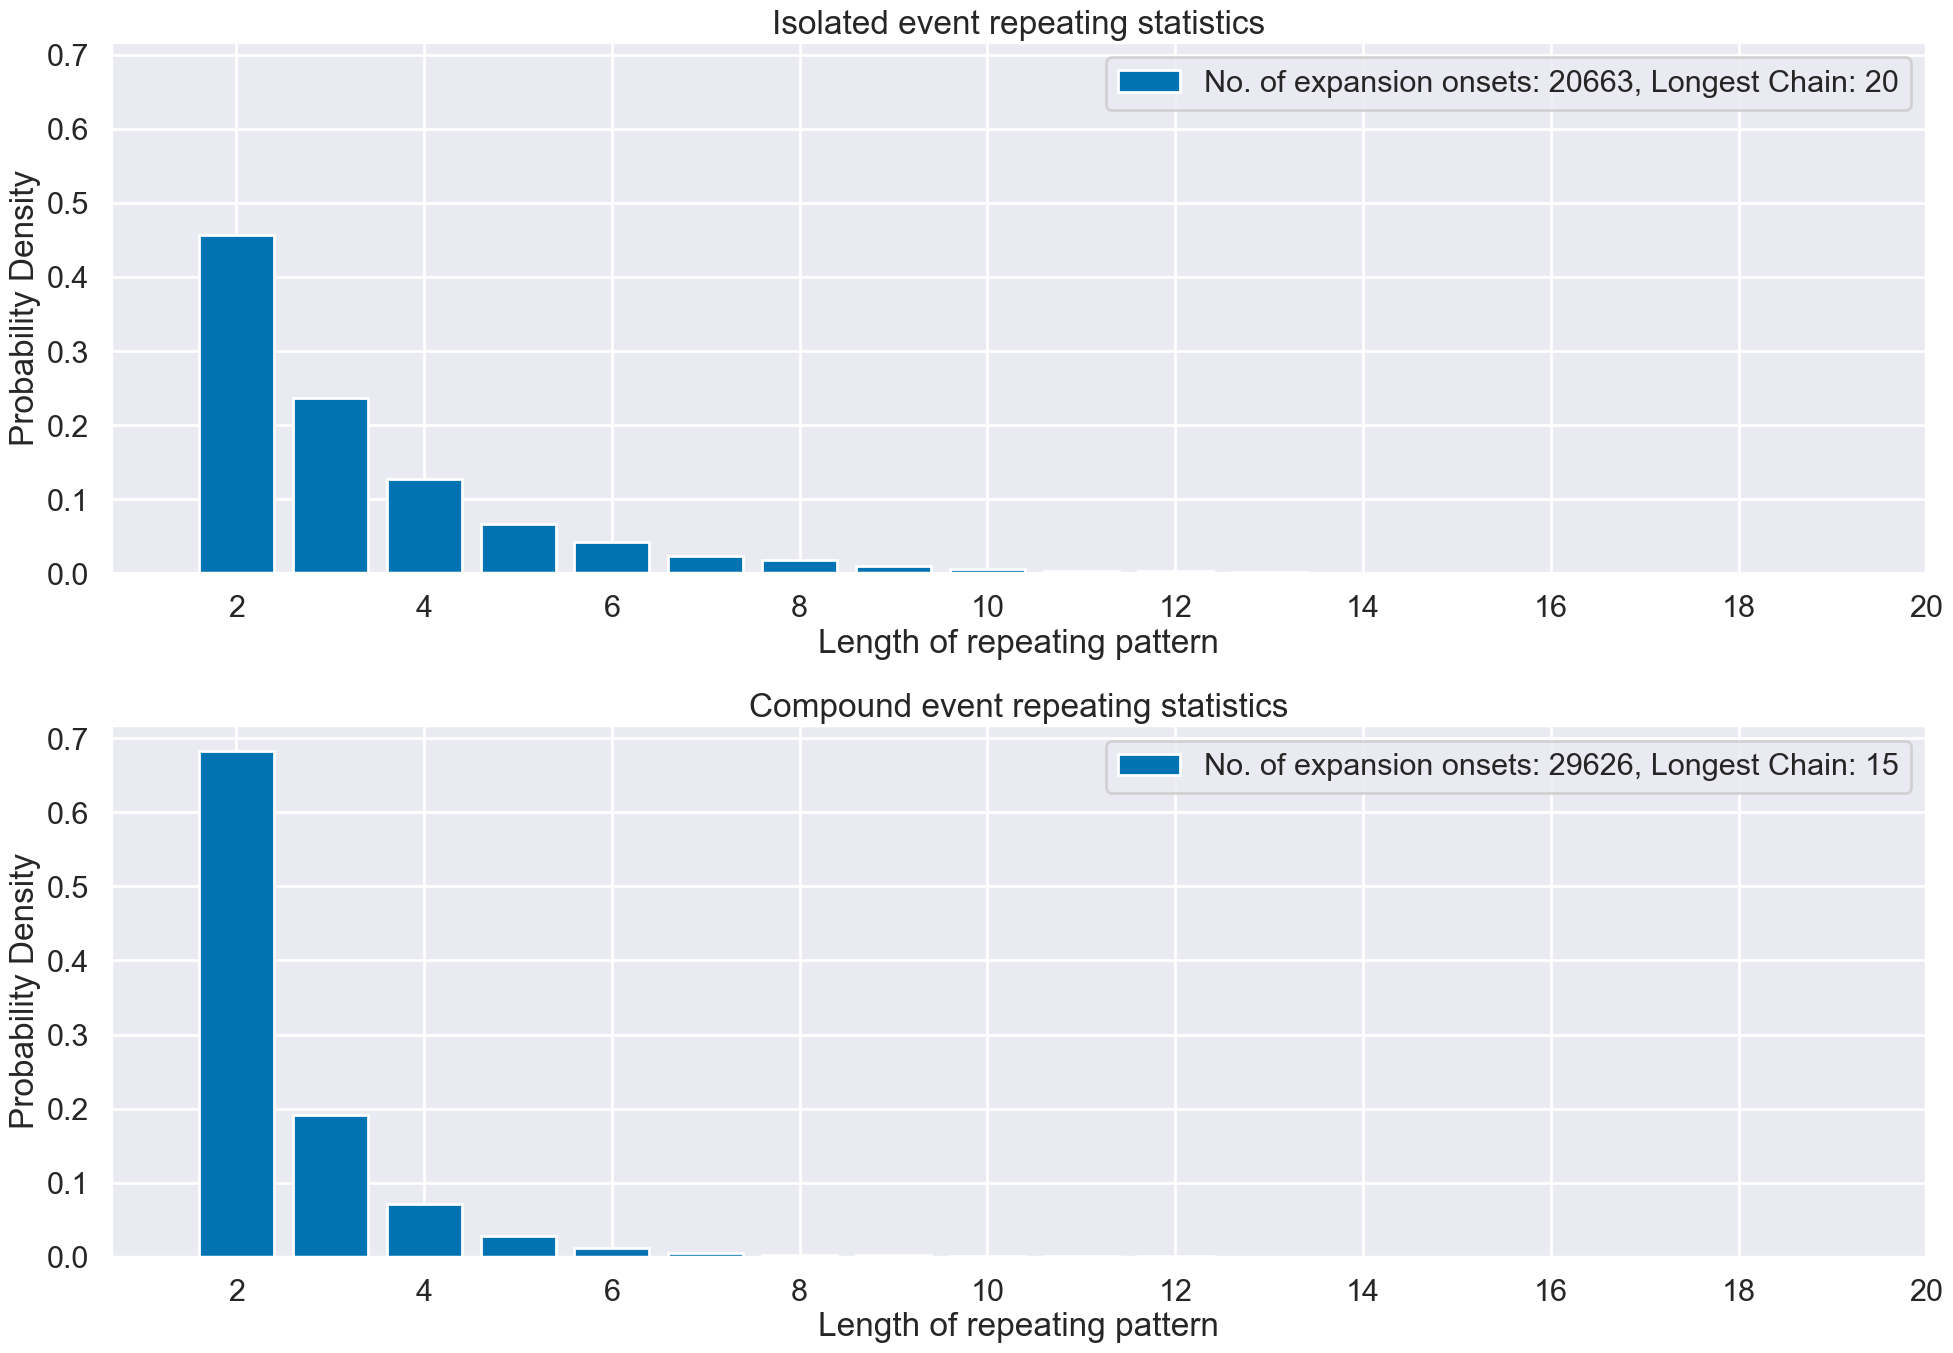

In [17]:
# Plotting chain lengths
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
s = np.zeros(len(sophie80onsetdf))
s[np.intersect1d(x,y)] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
# label = 'No. of expansion onsets: {}, Mean: {:.2f}, St. Dev: {:.2f}, Median: {:.2f}, Max: {}'.format(len(gergnoflag)+len(firstgerg),np.mean(co), np.std(co), np.median(co), np.max(co))
label = 'No. of expansion onsets: {}, Longest Chain: {}'.format(len(gergnoflag), np.max(co))
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1),density=True)
x = x[:-1]

fig, (ax, ax1) = plt.subplots(2,1, figsize=(20,14),sharex=True, sharey=True)
ax.bar(x,y,label=label)
ax.set_xlabel('Length of repeating pattern')
ax.set_ylabel('Probability Density')
ax.set_title("Isolated event repeating statistics")
# ax.legend(bbox_to_anchor=(1, .5), loc='center left')
ax.legend(loc='upper right')
ax.xaxis.set_tick_params(labelbottom=True)
ax.set_xlim(right=20)


x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
s = np.zeros(len(sophie80onsetdf))
s[np.intersect1d(x,y)] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
# label = 'No. of expansion onsets: {}, Mean: {:.2f}, St. Dev: {:.2f}, Median: {:.2f}, Max: {}'.format(len(erernoflag)+len(firster),np.mean(co), np.std(co), np.median(co), np.max(co))
label = 'No. of expansion onsets: {}, Longest Chain: {}'.format(len(erernoflag), np.max(co))
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1),density=True)
x = x[:-1]

ax1.bar(x,y,label=label)
ax1.set_xlabel('Length of repeating pattern')
ax1.set_ylabel('Probability Density')
ax1.set_title("Compound event repeating statistics")
# ax1.legend(bbox_to_anchor=(1, .5), loc='center left')
ax1.legend(loc='upper right')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))
fig.tight_layout(pad=1)


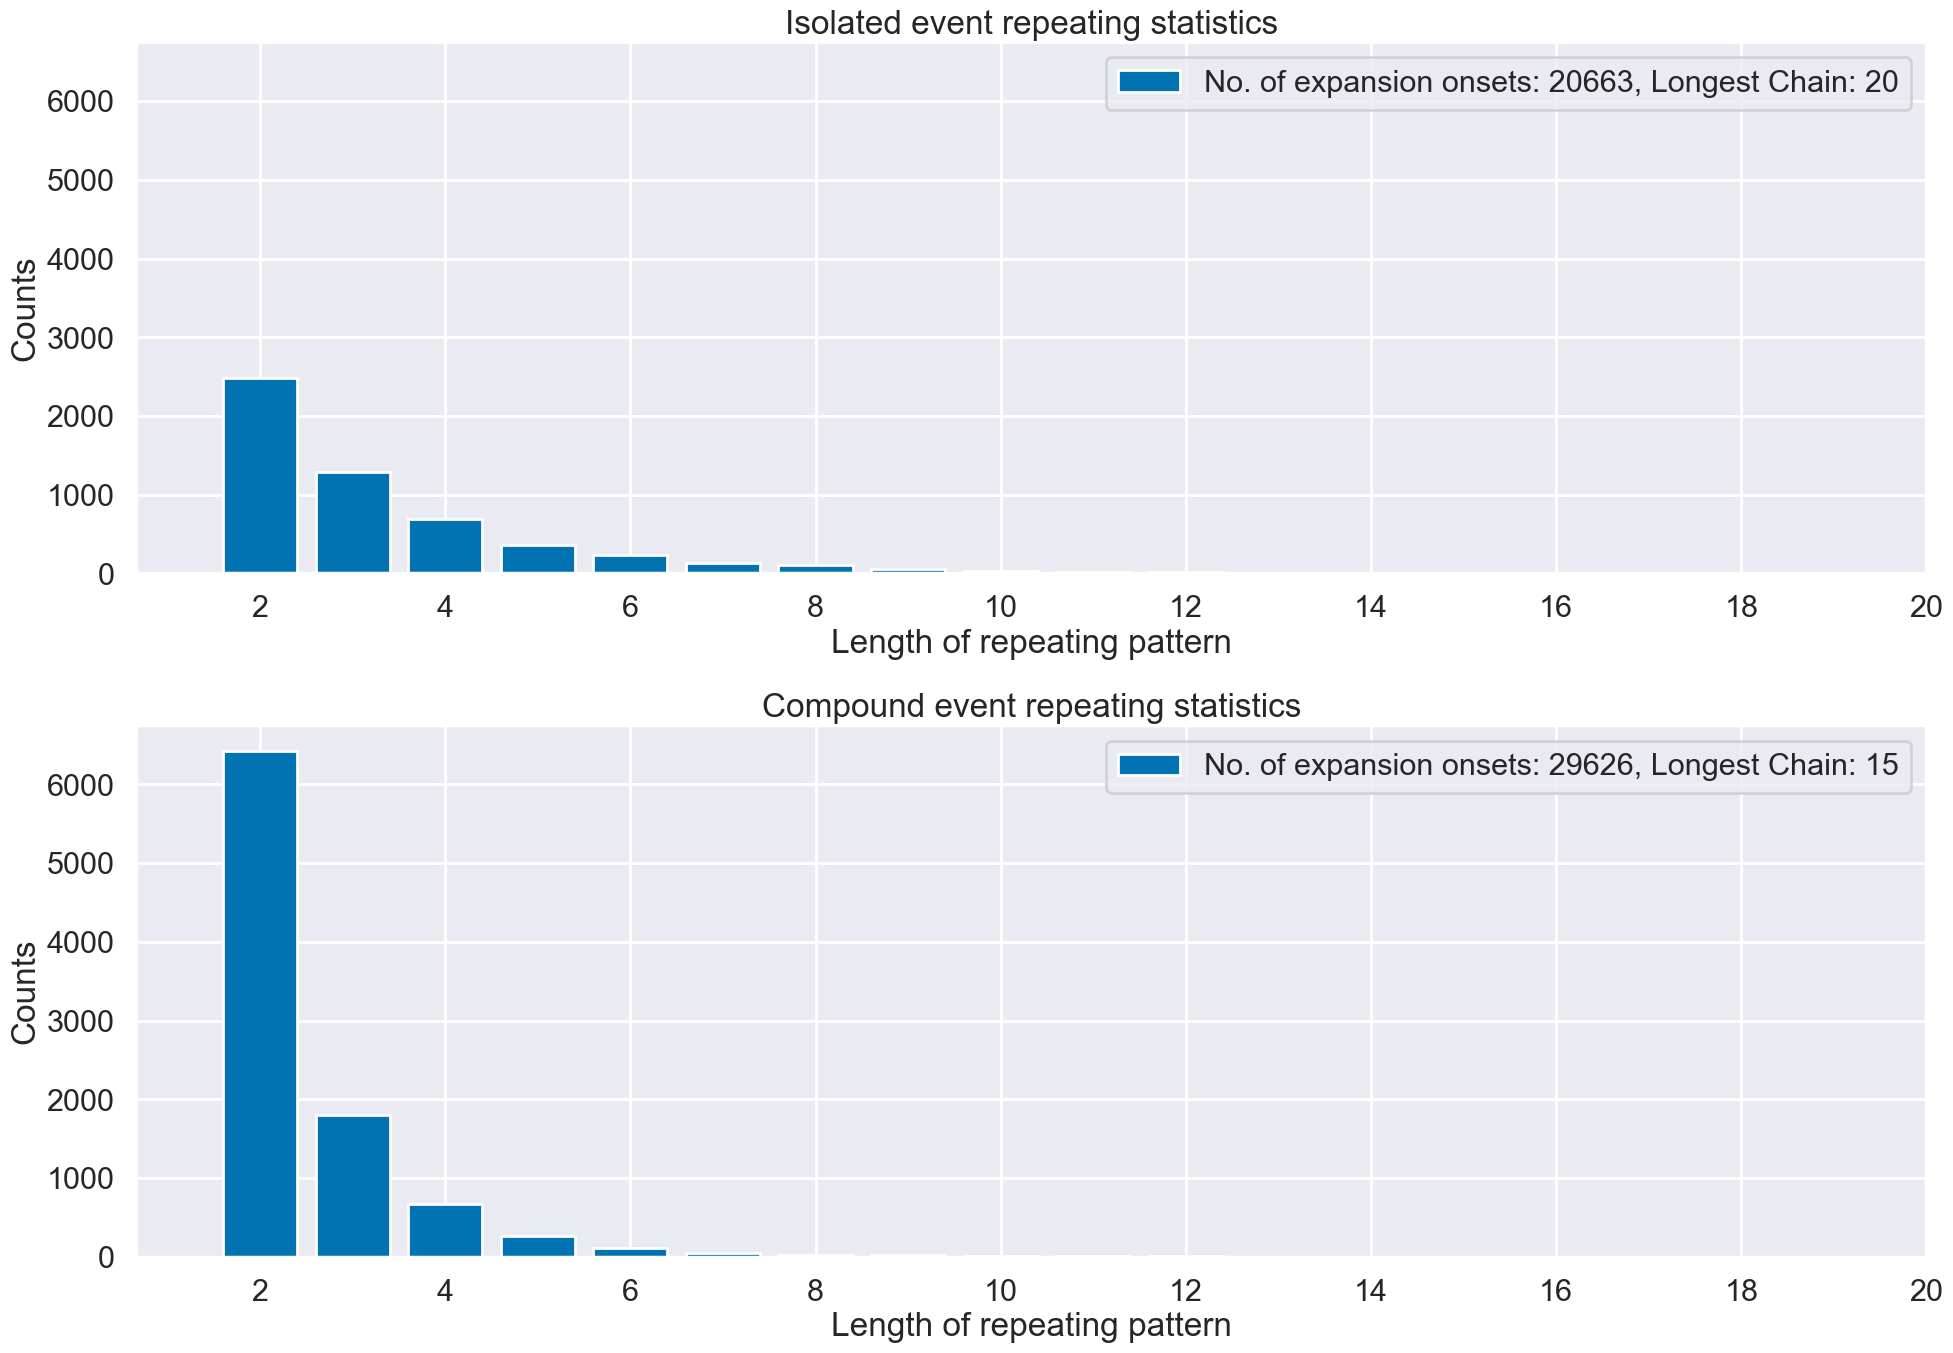

In [18]:
# Plotting chain lengths
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
s = np.zeros(len(sophie80onsetdf))
s[np.intersect1d(x,y)] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
# label = 'No. of expansion onsets: {}, Mean: {:.2f}, St. Dev: {:.2f}, Median: {:.2f}, Max: {}'.format(len(gergnoflag)+len(firstgerg),np.mean(co), np.std(co), np.median(co), np.max(co))
label = 'No. of expansion onsets: {}, Longest Chain: {}'.format(len(gergnoflag), np.max(co))
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1),density=False)
x = x[:-1]

fig, (ax, ax1) = plt.subplots(2,1, figsize=(20,14),sharex=True, sharey=True)
ax.bar(x,y,label=label)
ax.set_xlabel('Length of repeating pattern')
ax.set_ylabel('Counts')
ax.set_title("Isolated event repeating statistics")
ax.legend(loc='upper right')
ax.xaxis.set_tick_params(labelbottom=True)
ax.set_xlim(right=20)

x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
s = np.zeros(len(sophie80onsetdf))
s[np.intersect1d(x,y)] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
# label = 'No. of expansion onsets: {}, Mean: {:.2f}, St. Dev: {:.2f}, Median: {:.2f}, Max: {}'.format(len(erernoflag)+len(firster),np.mean(co), np.std(co), np.median(co), np.max(co))
label = 'No. of expansion onsets: {}, Longest Chain: {}'.format(len(erernoflag), np.max(co))
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1),density=False)
x = x[:-1]

ax1.bar(x,y,label=label)
ax1.set_xlabel('Length of repeating pattern')
ax1.set_ylabel('Counts')
ax1.set_title("Compound event repeating statistics")
ax1.legend(loc='upper right')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))
fig.tight_layout(pad=1)


[(2, 2477), (3, 1286), (4, 691), (5, 364), (6, 230), (7, 131), (8, 101), (9, 54), (10, 31), (11, 21), (12, 16), (13, 8), (14, 1), (15, 4), (16, 0), (17, 3), (18, 1), (19, 0), (20, 1)]


Text(0.5, 1.01, 'Isolated event repeating statistics')

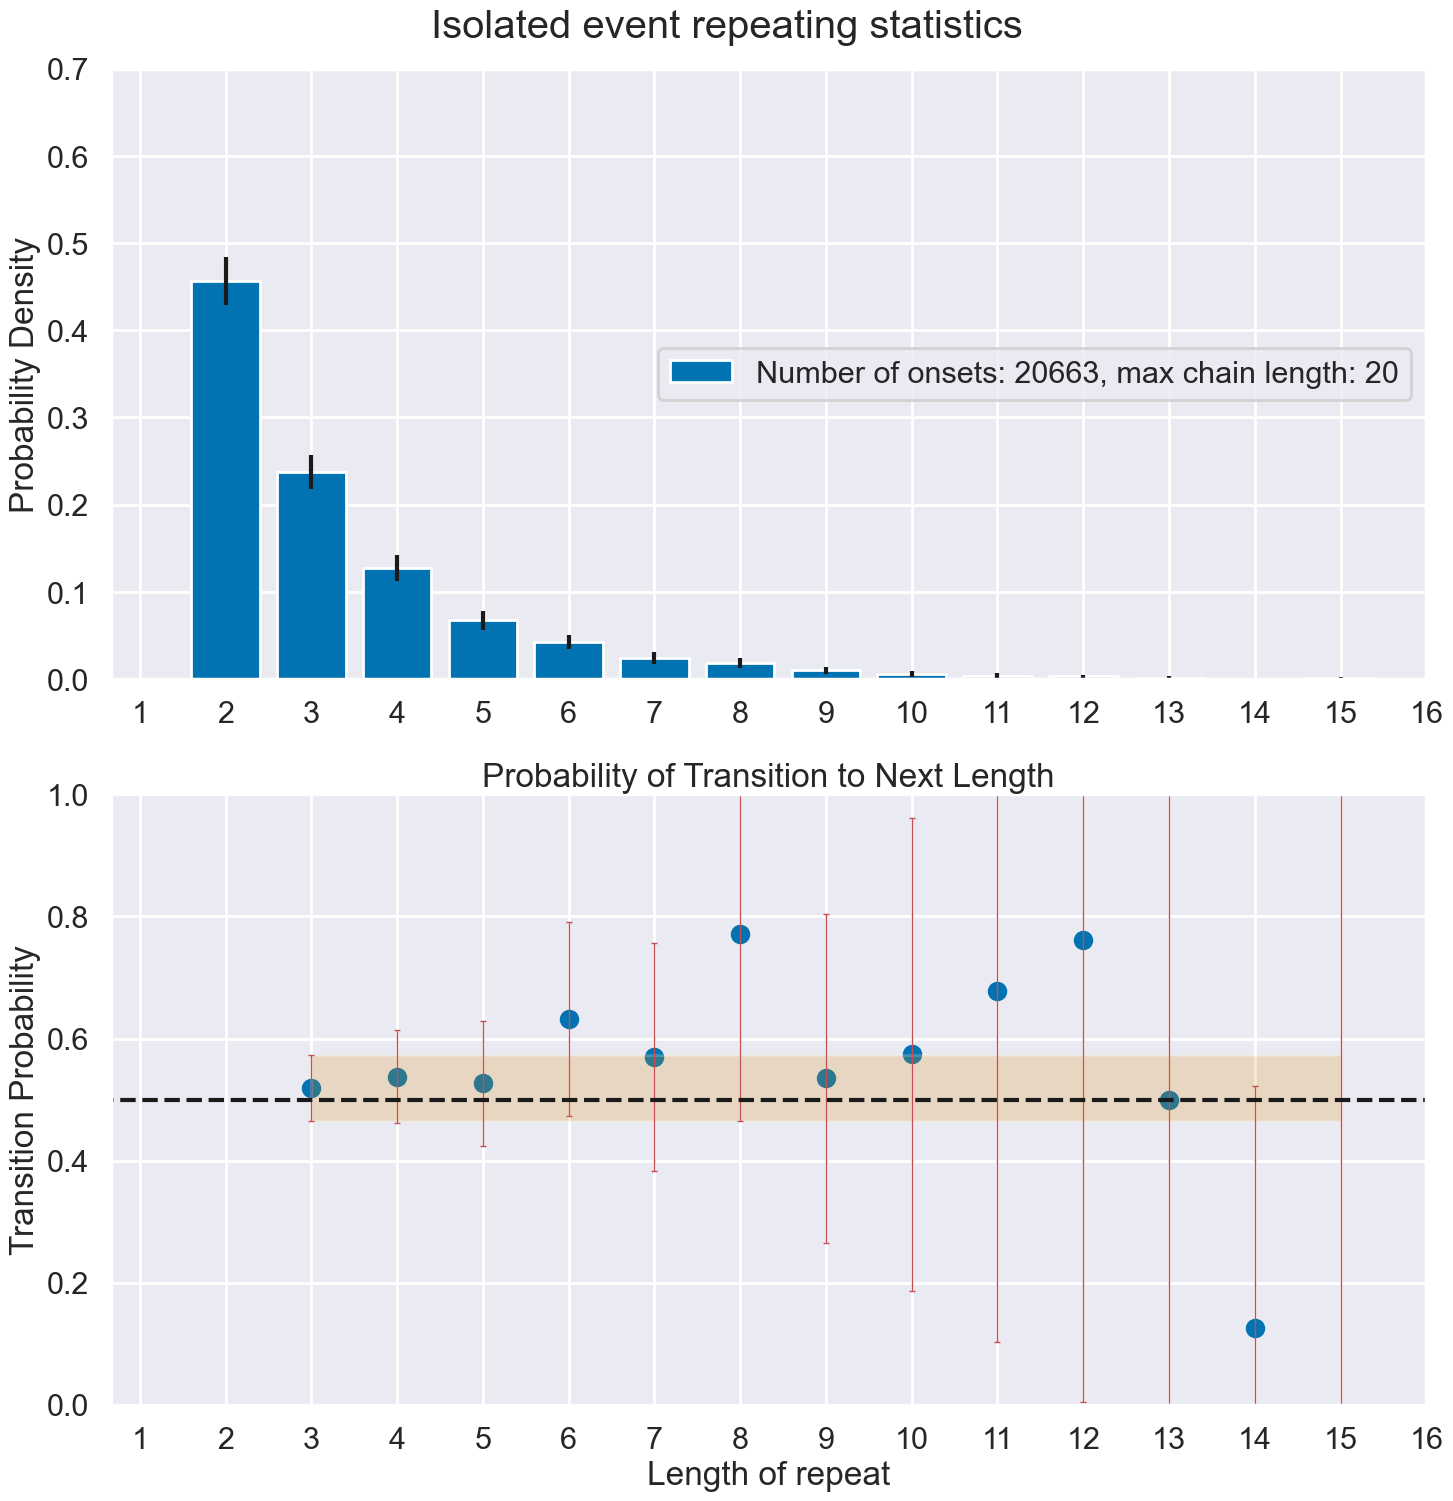

In [19]:
# Analysis of gerg chain lengths
x = np.where(sophie80onsetdf['GERG']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]

y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x = x[:-1]
yerror = [np.sqrt(i) for i in y]
print(list(zip(x,y)))
if np.where(y==0)[0].size > 0:
    yanalysis = y[:np.where(y==0)[0][0]]
else:
    yanalysis = y


yerror = yerror/np.sum(y)
yerror = 3*yerror
y = y/np.sum(y)
yanalysis = yanalysis/sum(yanalysis)

ratio = np.array([yanalysis[i]/yanalysis[i-1] for i in range(1,len(yanalysis))])
ratioerror = np.array([np.sqrt((yerror[i]/yanalysis[i])**2 + (yerror[i-1]/yanalysis[i-1])**2) for i in range(1,len(yanalysis))])
ratioerror = ratioerror*ratio

fig, (ax, ax1) = plt.subplots(2,1,sharex=True,figsize=(15,15))

ax.bar(x,y,yerr=yerror,label='Number of onsets: {}, max chain length: {}'.format(len(gergnoflag),np.max(co)))
ax.legend(loc='center right')
ax.set_ylabel('Probability Density')
ax.set_xlim(right=16)
ax.set_ylim(0, 0.7)
ax.xaxis.set_tick_params(labelbottom=True)

ax1.scatter(x[:len(ratio)]+1, ratio[:len(ratio)])
ax1.errorbar(x[:len(ratio)]+1, ratio[:len(ratio)], yerr=ratioerror, fmt='none', ecolor='r', elinewidth=1, capsize=2)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_xlabel("Length of repeat")
ax1.set_ylabel('Transition Probability')
ax1.set_title("Probability of Transition to Next Length")
ax1.set_ylim(0,1)
ax1.fill_between(x[:len(ratio)]+1, ratio[0]-ratioerror[0], ratio[0]+ratioerror[0], alpha=0.2)
ax1.hlines(0.5,0,16,linestyles='dashed',colors='k')


fig.tight_layout(pad=1)
fig.suptitle('Isolated event repeating statistics',y=1.01)


[(2, 6427), (3, 1803), (4, 665), (5, 270), (6, 117), (7, 54), (8, 27), (9, 20), (10, 11), (11, 5), (12, 6), (13, 1), (14, 1), (15, 1)]


Text(0.5, 1.01, 'Compound event repeating statistics')

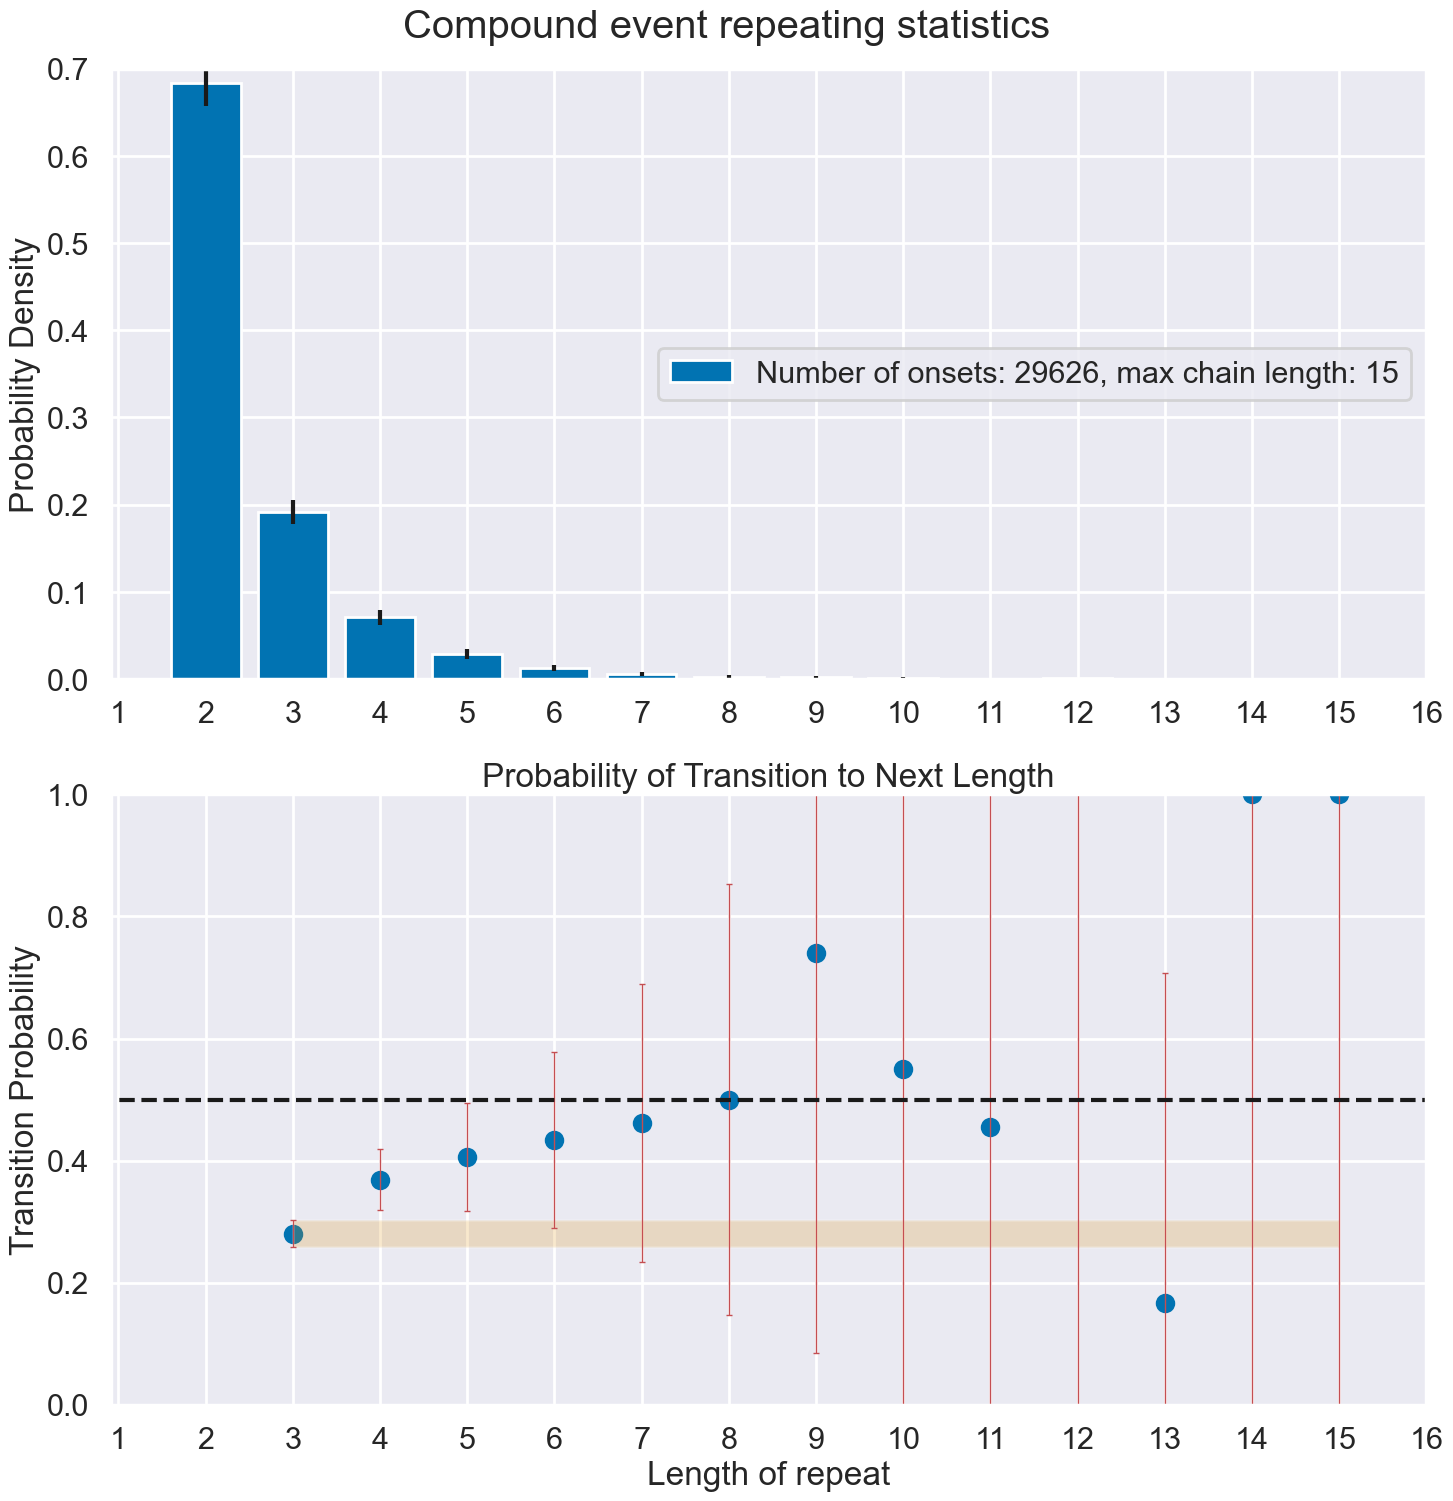

In [20]:
# Analysis of erer chain lengths
x = np.where(sophie80onsetdf['ERER']==1)[0]
y = np.where(sophie80onsetdf['Flag']==0)[0]
indices_onsets =np.intersect1d(x,y)
s = np.zeros(len(sophie80onsetdf))
s[indices_onsets] = True
s = pd.Series(s.astype(bool))
co = (~s).cumsum()[s].value_counts().to_list()
co = [i+1 for i in co]
y, x = np.histogram(co, bins=np.arange(2,np.max(co)+2,1))
x = x[:-1]
print(list(zip(x,y)))
yerror = [np.sqrt(i) for i in y]
if np.where(y==0)[0].size > 0:
    yanalysis = y[:np.where(y==0)[0][0]]
else:
    yanalysis = y

yerror = yerror/np.sum(y)
yerror = 3*yerror
y = y/np.sum(y)
yanalysis = yanalysis/sum(yanalysis)


ratio = np.array([yanalysis[i]/yanalysis[i-1] for i in range(1,len(yanalysis))])
ratioerror = np.array([np.sqrt((yerror[i]/yanalysis[i])**2 + (yerror[i-1]/yanalysis[i-1])**2) for i in range(1,len(yanalysis))])
ratioerror = ratioerror*ratio

fig, (ax, ax1) = plt.subplots(2,1,sharex=True,figsize=(15,15))

ax.bar(x,y,yerr=yerror,label='Number of onsets: {}, max chain length: {}'.format(len(erernoflag),np.max(co)))
ax.legend(loc='center right')
ax.set_ylabel('Probability Density')
ax.set_xlim(right=16)
ax.set_ylim(0, 0.7)
ax.xaxis.set_tick_params(labelbottom=True)

ax1.scatter(x[:len(ratio)]+1, ratio[:len(ratio)])
ax1.errorbar(x[:len(ratio)]+1, ratio[:len(ratio)], yerr=ratioerror, fmt='none', ecolor='r', elinewidth=1, capsize=2)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_xlabel("Length of repeat")
ax1.set_ylabel('Transition Probability')
ax1.set_title("Probability of Transition to Next Length")
ax1.set_ylim(0,1)
ax1.fill_between(x[:len(ratio)]+1, ratio[0]-ratioerror[0], ratio[0]+ratioerror[0], alpha=0.2)
ax1.hlines(0.5,0,16,linestyles='dashed',colors='k')


fig.tight_layout(pad=1)
fig.suptitle("Compound event repeating statistics", y=1.01)